# About this notebook
- Deberta-v3-base starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/fb3-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/yasufuminakama/fb3-deberta-v3-base-baseline-inference)

If this notebook is helpful, feel free to upvote :)

# Directory settings

In [1]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# CFG

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=True
    competition='Amazon'
    _wandb_kernel='gunjan'
    debug=False
    apex=True
    print_freq=20
    num_workers=4
    model="microsoft/deberta-v3-base"
    gradient_checkpointing=True
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=8
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_cols=['PRODUCT_LENGTH']
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [4]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        # wandb.login(key=secret_value_0)
        wandb.login()
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='FB3-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gunjandhanuka. Use `wandb login --relogin` to force relogin


# Library

In [4]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# os.system('pip install iterative-stratification==0.1.7')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

# os.system('pip uninstall -y transformers')
# os.system('pip uninstall -y tokenizers')
# os.system('python -m pip install --no-index --find-links=../input/fb3-pip-wheels transformers')
# os.system('python -m pip install --no-index --find-links=../input/fb3-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizers.__version__: 0.13.3
transformers.__version__: 4.28.1
env: TOKENIZERS_PARALLELISM=true


# Utils

In [5]:
# ====================================================
# Utils
# ====================================================
def MCRMSE(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:,i]
        y_pred = y_preds[:,i]
        score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score, scores


def get_score(y_trues, y_preds):
    mcrmse_score, scores = MCRMSE(y_trues, y_preds)
    return mcrmse_score, scores


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [6]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv('datasetb2d9982/dataset/train.csv')
test = pd.read_csv('datasetb2d9982/dataset/test.csv')
submission = pd.read_csv('datasetb2d9982/dataset/sample_submission.csv')

print(f"train.shape: {train.shape}")
display(train.head())
print(f"test.shape: {test.shape}")
display(test.head())
print(f"submission.shape: {submission.shape}")
display(submission.head())

train.shape: (2249698, 6)


,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH
0,1925202,ArtzFolio Tulip Flowers Blackout Curtain for D...,[LUXURIOUS & APPEALING: Beautiful custom-made ...,NaN,1650,2125.980000
1,2673191,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...,"[Harry Potter Hedwig Pyjamas (6-16 Yrs),100% c...",NaN,2755,393.700000
2,2765088,PRIKNIK Horn Red Electric Air Horn Compressor ...,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495
3,1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574
4,283658,The United Empire Loyalists: A Chronicle of th...,NaN,NaN,6112,598.424000


test.shape: (734736, 5)


,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID
0,604373,Manuel d'Héliogravure Et de Photogravure En Re...,NaN,NaN,6142
1,1729783,DCGARING Microfiber Throw Blanket Warm Fuzzy P...,[QUALITY GUARANTEED: Luxury cozy plush polyest...,<b>DCGARING Throw Blanket</b><br><br> <b>Size ...,1622
2,1871949,I-Match Auto Parts Front License Plate Bracket...,"[Front License Plate Bracket Made Of Plastic,D...",Replacement for The Following Vehicles:2020 LE...,7540
3,1107571,PinMart Gold Plated Excellence in Service 1 Ye...,[Available as a single item or bulk packed. Se...,Our Excellence in Service Lapel Pins feature a...,12442
4,624253,"Visual Mathematics, Illustrated by the TI-92 a...",NaN,NaN,6318


submission.shape: (734736, 2)


,PRODUCT_ID,PRODUCT_LENGTH
0,604373,701.093794
1,1729783,734.506163
2,1871949,741.360258
3,1107571,730.327767
4,624253,666.847946


In [6]:
import seaborn as sns

<AxesSubplot: >

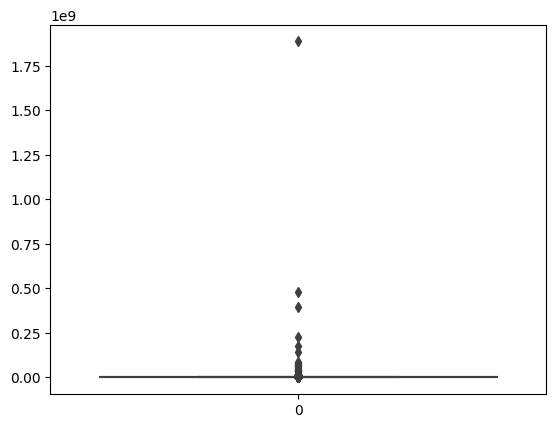

In [9]:
sns.boxplot(train['PRODUCT_LENGTH'])

In [7]:
# create a new column with log of PRODUCT_LENGTH
train['PRODUCT_LENGTH_log'] = np.log10(train['PRODUCT_LENGTH'])

In [15]:
# find the percentage of total values with log between 0 and 1, 1 and 2, 2 and 3, 3 and 4
train['PRODUCT_LENGTH_log'].value_counts(bins=4, normalize=True)

(2.319, 4.638]                    0.924831
(-0.010280000000000001, 2.319]    0.073894
(4.638, 6.957]                    0.001230
(6.957, 9.275]                    0.000045
Name: PRODUCT_LENGTH_log, dtype: float64

In [8]:
# remove the outliers
train = train[train['PRODUCT_LENGTH_log'] < 3.5]
train.shape

(2130211, 7)

In [9]:
# remove the outliers which have very small PRODUCT_LENGTH_log
train = train[train['PRODUCT_LENGTH_log'] > 1]
train.shape

(2119965, 7)

In [19]:
# groupby PRODUCT_ID and find mean, max and min of PRODUCT_LENGTH
train.groupby('PRODUCT_ID')['PRODUCT_LENGTH'].agg(['mean', 'max', 'min'])

,mean,max,min
PRODUCT_ID,,,
1,307.000000,307.000000,307.000000
5,39.370079,39.370079,39.370079
7,300.000000,300.000000,300.000000
8,842.518000,842.518000,842.518000
10,866.141731,866.141731,866.141731
...,...,...,...
2999993,1062.992125,1062.992125,1062.992125
2999994,245.000000,245.000000,245.000000
2999995,2360.000000,2360.000000,2360.000000


<AxesSubplot: xlabel='PRODUCT_LENGTH', ylabel='Density'>

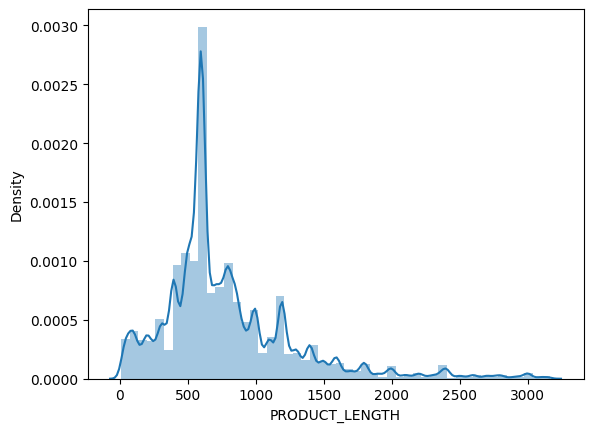

In [20]:
# plot the distribution of PRODUCT_LENGTH
sns.distplot(train['PRODUCT_LENGTH'])

In [3]:
import pandas as pd
test = pd.read_csv('datasetb2d9982/dataset/test.csv')
test.isna().sum()

PRODUCT_ID              0
TITLE                   5
BULLET_POINTS      275922
DESCRIPTION        380001
PRODUCT_TYPE_ID         0
dtype: int64

<AxesSubplot: xlabel='PRODUCT_LENGTH', ylabel='Count'>

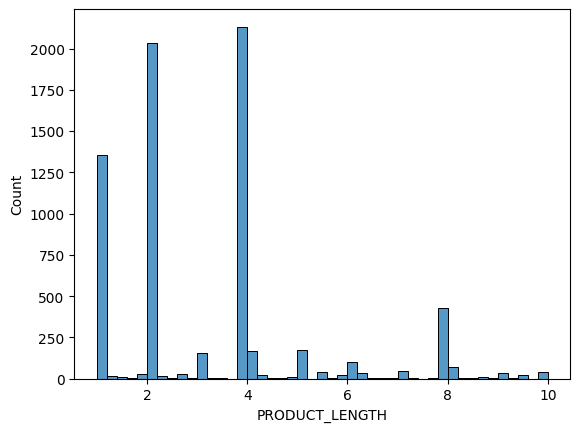

In [10]:
sns.histplot(train[train['PRODUCT_LENGTH'] < 10]['PRODUCT_LENGTH'])

In [14]:
# find out unique values of each column
for col in train.columns:
    print(f"{col}: {train[col].nunique()}")

PRODUCT_ID: 2119965
TITLE: 2083160
BULLET_POINTS: 881892
DESCRIPTION: 693087
PRODUCT_TYPE_ID: 12668
PRODUCT_LENGTH: 10972
PRODUCT_LENGTH_log: 10933


In [15]:
# check if there are any null values
train.isnull().sum()

PRODUCT_ID                  0
TITLE                      12
BULLET_POINTS          826370
DESCRIPTION           1112082
PRODUCT_TYPE_ID             0
PRODUCT_LENGTH              0
PRODUCT_LENGTH_log          0
dtype: int64

<AxesSubplot: xlabel='PRODUCT_LENGTH_log', ylabel='Density'>

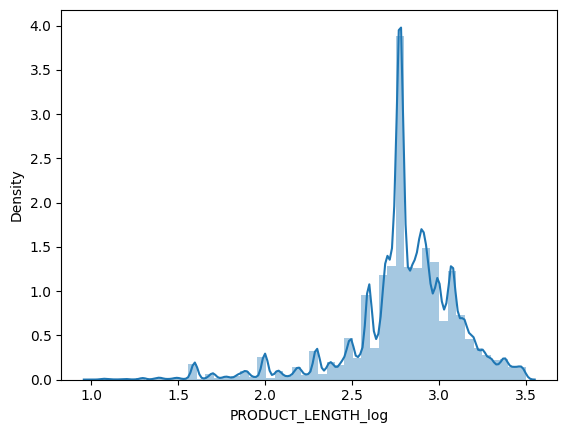

In [18]:
sns.distplot(train['PRODUCT_LENGTH_log'])

<AxesSubplot: >

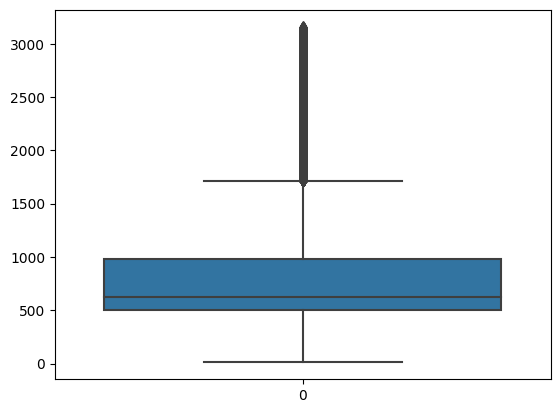

In [17]:
sns.boxplot(train['PRODUCT_LENGTH'])

In [28]:
# check the relation between PRODUCT_ID and PRODUCT_LENGTH
train.groupby('PRODUCT_TYPE_ID')['PRODUCT_LENGTH'].agg(['mean', 'max', 'min'])

,mean,max,min
PRODUCT_TYPE_ID,,,
0,710.401786,3150.00000,10.23622
1,658.903399,3031.49606,10.82675
2,895.533344,2992.00000,14.99997
3,459.979209,1354.00000,15.74800
4,700.239977,3150.00000,11.00000
...,...,...,...
13416,1270.071541,2460.00000,100.00000
13417,1172.500000,1820.00000,525.00000
13418,1233.333333,1300.00000,1100.00000


In [22]:
train.shape

(2119965, 7)

In [23]:
df_train = train.copy()

In [27]:
train['PRODUCT_TYPE_ID'].nunique()

2119965

In [30]:
# iterate through all PRODUCT_ID and remove all the rows which have PRODUCT_LENGTH greater than 99 percentile of PRODUCT_LENGTH of that PRODUCT_ID
for product_id in tqdm(df_train['PRODUCT_TYPE_ID'].unique()):
    product_length_99 = np.percentile(df_train[df_train['PRODUCT_TYPE_ID'] == product_id]['PRODUCT_LENGTH'], 99)
    df_train = df_train[~((df_train['PRODUCT_TYPE_ID'] == product_id) & (df_train['PRODUCT_LENGTH'] > product_length_99))]

  0%|          | 0/12668 [00:00<?, ?it/s]

In [34]:
df_train.to_csv("outlier_removed.csv", index=False)

In [ ]:
# get deberta embeddings for the TITLE column
def get_deberta_embeddings(df, col_name):
    tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-base')
    model = AutoModel.from_pretrained('microsoft/deberta-base')
    model.to(device)
    model.eval()
    df[col_name + '_deberta_embeddings'] = df[col_name].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
    df[col_name + '_deberta_embeddings'] = df[col_name + '_deberta_embeddings'].apply(lambda x: torch.tensor(x).unsqueeze(0).to(device))
    df[col_name + '_deberta_embeddings'] = df[col_name + '_deberta_embeddings'].apply(lambda x: model(x)[0][0][0].detach().cpu().numpy())
    return df

df_train = get_deberta_embeddings(df_train, 'TITLE')

In [10]:
train_clean = train.dropna(axis=0, subset='TITLE')
train_clean.isna().sum()

PRODUCT_ID                  0
TITLE                       0
BULLET_POINTS          826360
DESCRIPTION           1112070
PRODUCT_TYPE_ID             0
PRODUCT_LENGTH              0
PRODUCT_LENGTH_log          0
dtype: int64

In [12]:
# get the tfidf embeddings of the TITLE column and save as numpy file
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1024)
tfidf.fit(train_clean['TITLE'])
tfidf_embeddings = tfidf.transform(train_clean['TITLE'])
tfidf_embeddings = tfidf_embeddings.toarray()
np.save('TITLE_tfidf_embeddings.npy', tfidf_embeddings)

: 

: 

# CV split

In [7]:
# ====================================================
# CV split
# ====================================================
Fold = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train[CFG.target_cols])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    978
1    977
2    978
3    978
dtype: int64

In [8]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [9]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [10]:
# ====================================================
# Define max_len
# ====================================================
lengths = []
tk0 = tqdm(train['full_text'].fillna("").values, total=len(train))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
CFG.max_len = max(lengths) + 3 # cls & sep & sep
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/3911 [00:00<?, ?it/s]

max_len: 1429


In [11]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True, 
        max_length=CFG.max_len,
        pad_to_max_length=True,
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['full_text'].values
        self.labels = df[cfg.target_cols].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label
    

def collate(inputs):
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

# Model

In [12]:
# ====================================================
# Model
# ====================================================
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings
    

class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel(self.config)
        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()
        self.pool = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, 6)
        self._init_weights(self.fc)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, inputs['attention_mask'])
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(feature)
        return output

# Loss

In [13]:
# ====================================================
# Loss
# ====================================================
class RMSELoss(nn.Module):
    def __init__(self, reduction='mean', eps=1e-9):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')
        self.reduction = reduction
        self.eps = eps

    def forward(self, y_pred, y_true):
        loss = torch.sqrt(self.mse(y_pred, y_true) + self.eps)
        if self.reduction == 'none':
            loss = loss
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'mean':
            loss = loss.mean()
        return loss

# Helpler functions

In [14]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        inputs = collate(inputs)
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        inputs = collate(inputs)
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# train loop

In [15]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.SmoothL1Loss(reduction='mean') # RMSELoss(reduction="mean")
    
    best_score = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score, scores = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {scores}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score > score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds[[f"pred_{c}" for c in CFG.target_cols]] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [16]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df[CFG.target_cols].values
        preds = oof_df[[f"pred_{c}" for c in CFG.target_cols]].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}  Scores: {scores}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========
DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
  "share_att_key": true,
  "transformers_version": "4.21.2",
  "type_vocab_size": 0,
  "vocab_size": 128100
}



Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/366] Elapsed 0m 2s (remain 17m 36s) Loss: 2.3540(2.3540) Grad: inf  LR: 0.00002000  
Epoch: [1][20/366] Elapsed 0m 39s (remain 10m 47s) Loss: 0.3457(1.3300) Grad: 183214.3438  LR: 0.00001999  
Epoch: [1][40/366] Elapsed 1m 15s (remain 10m 1s) Loss: 0.1143(0.7888) Grad: 59873.2031  LR: 0.00001996  
Epoch: [1][60/366] Elapsed 1m 48s (remain 9m 3s) Loss: 0.1742(0.5885) Grad: 163035.2656  LR: 0.00001991  
Epoch: [1][80/366] Elapsed 2m 26s (remain 8m 34s) Loss: 0.1442(0.4814) Grad: 85090.5391  LR: 0.00001985  
Epoch: [1][100/366] Elapsed 3m 9s (remain 8m 16s) Loss: 0.0982(0.4215) Grad: 63492.4805  LR: 0.00001977  
Epoch: [1][120/366] Elapsed 3m 45s (remain 7m 36s) Loss: 0.1821(0.3740) Grad: 93093.6797  LR: 0.00001967  
Epoch: [1][140/366] Elapsed 4m 23s (remain 7m 0s) Loss: 0.1646(0.3376) Grad: 87037.5078  LR: 0.00001955  
Epoch: [1][160/366] Elapsed 4m 59s (remain 6m 20s) Loss: 0.1169(0.3099) Grad: 74544.7969  LR: 0.00001941  
Epoch: [1][180/366] Elapsed 5m 35s (remain 5m 43s)

Epoch 1 - avg_train_loss: 0.2027  avg_val_loss: 0.1059  time: 740s
Epoch 1 - Score: 0.4606  Scores: [0.4996937629771907, 0.45632419741462044, 0.41798291067803384, 0.4622002538982251, 0.4752168053338235, 0.45205017601158254]
Epoch 1 - Save Best Score: 0.4606 Model


EVAL: [60/62] Elapsed 1m 17s (remain 0m 1s) Loss: 0.0992(0.1058) 
EVAL: [61/62] Elapsed 1m 17s (remain 0m 0s) Loss: 0.1202(0.1059) 
Epoch: [2][0/366] Elapsed 0m 1s (remain 8m 2s) Loss: 0.1071(0.1071) Grad: 164300.7500  LR: 0.00001706  
Epoch: [2][20/366] Elapsed 0m 30s (remain 8m 22s) Loss: 0.1587(0.1029) Grad: 208521.5469  LR: 0.00001675  
Epoch: [2][40/366] Elapsed 1m 8s (remain 9m 6s) Loss: 0.0898(0.1054) Grad: 130959.6250  LR: 0.00001643  
Epoch: [2][60/366] Elapsed 1m 52s (remain 9m 21s) Loss: 0.1196(0.1041) Grad: 95220.3516  LR: 0.00001610  
Epoch: [2][80/366] Elapsed 2m 30s (remain 8m 49s) Loss: 0.0756(0.1024) Grad: 64189.5469  LR: 0.00001575  
Epoch: [2][100/366] Elapsed 3m 5s (remain 8m 7s) Loss: 0.1594(0.1028) Grad: 204060.7812  LR: 0.00001540  
Epoch: [2][120/366] Elapsed 3m 43s (remain 7m 32s) Loss: 0.1119(0.1032) Grad: 84227.4922  LR: 0.00001503  
Epoch: [2][140/366] Elapsed 4m 18s (remain 6m 52s) Loss: 0.0818(0.1024) Grad: 35142.7266  LR: 0.00001466  
Epoch: [2][160/366] 

Epoch 2 - avg_train_loss: 0.1014  avg_val_loss: 0.1044  time: 733s
Epoch 2 - Score: 0.4572  Scores: [0.5009202521149595, 0.44924937811567284, 0.41062599249253223, 0.4596381490058948, 0.46839863600657716, 0.45438341550524963]
Epoch 2 - Save Best Score: 0.4572 Model


EVAL: [60/62] Elapsed 1m 16s (remain 0m 1s) Loss: 0.0942(0.1044) 
EVAL: [61/62] Elapsed 1m 16s (remain 0m 0s) Loss: 0.1208(0.1044) 
Epoch: [3][0/366] Elapsed 0m 1s (remain 9m 56s) Loss: 0.1090(0.1090) Grad: 276447.3438  LR: 0.00001000  
Epoch: [3][20/366] Elapsed 0m 32s (remain 8m 54s) Loss: 0.0736(0.0944) Grad: 90174.6250  LR: 0.00000957  
Epoch: [3][40/366] Elapsed 1m 8s (remain 9m 5s) Loss: 0.0704(0.0941) Grad: 57685.8008  LR: 0.00000914  
Epoch: [3][60/366] Elapsed 1m 49s (remain 9m 7s) Loss: 0.0585(0.0926) Grad: 99230.8984  LR: 0.00000872  
Epoch: [3][80/366] Elapsed 2m 23s (remain 8m 24s) Loss: 0.0792(0.0922) Grad: 73890.3828  LR: 0.00000829  
Epoch: [3][100/366] Elapsed 3m 2s (remain 7m 58s) Loss: 0.0664(0.0929) Grad: 98066.6016  LR: 0.00000787  
Epoch: [3][120/366] Elapsed 3m 40s (remain 7m 27s) Loss: 0.1012(0.0939) Grad: 66695.2578  LR: 0.00000746  
Epoch: [3][140/366] Elapsed 4m 14s (remain 6m 46s) Loss: 0.0593(0.0945) Grad: 109744.5000  LR: 0.00000704  
Epoch: [3][160/366] E

Epoch 3 - avg_train_loss: 0.0943  avg_val_loss: 0.1028  time: 736s
Epoch 3 - Score: 0.4537  Scores: [0.49301247466474357, 0.44503414597460406, 0.4122512428618351, 0.46006913786745646, 0.4680419432842684, 0.4440455478770819]
Epoch 3 - Save Best Score: 0.4537 Model


EVAL: [60/62] Elapsed 1m 16s (remain 0m 1s) Loss: 0.0868(0.1028) 
EVAL: [61/62] Elapsed 1m 16s (remain 0m 0s) Loss: 0.1058(0.1028) 
Epoch: [4][0/366] Elapsed 0m 2s (remain 15m 32s) Loss: 0.1196(0.1196) Grad: 384991.8438  LR: 0.00000294  
Epoch: [4][20/366] Elapsed 0m 37s (remain 10m 22s) Loss: 0.0621(0.0883) Grad: 161876.4688  LR: 0.00000264  
Epoch: [4][40/366] Elapsed 1m 12s (remain 9m 31s) Loss: 0.0894(0.0899) Grad: 210579.4531  LR: 0.00000236  
Epoch: [4][60/366] Elapsed 1m 46s (remain 8m 52s) Loss: 0.0821(0.0874) Grad: 190035.7188  LR: 0.00000209  
Epoch: [4][80/366] Elapsed 2m 23s (remain 8m 23s) Loss: 0.1459(0.0889) Grad: 195586.3906  LR: 0.00000183  
Epoch: [4][100/366] Elapsed 3m 1s (remain 7m 55s) Loss: 0.1187(0.0910) Grad: 152261.7812  LR: 0.00000159  
Epoch: [4][120/366] Elapsed 3m 37s (remain 7m 20s) Loss: 0.1034(0.0911) Grad: 245069.0781  LR: 0.00000137  
Epoch: [4][140/366] Elapsed 4m 9s (remain 6m 37s) Loss: 0.0802(0.0898) Grad: 119867.1562  LR: 0.00000116  
Epoch: [4][

Epoch 4 - avg_train_loss: 0.0883  avg_val_loss: 0.1018  time: 733s
Epoch 4 - Score: 0.4514  Scores: [0.48969456742073625, 0.44272521674521353, 0.4098073525259803, 0.45862207070131683, 0.4661503746510145, 0.44167336097820015]
Epoch 4 - Save Best Score: 0.4514 Model


EVAL: [60/62] Elapsed 1m 16s (remain 0m 1s) Loss: 0.0887(0.1018) 
EVAL: [61/62] Elapsed 1m 16s (remain 0m 0s) Loss: 0.0977(0.1018) 


========== fold: 0 result ==========
Score: 0.4514  Scores: [0.48969456742073625, 0.44272521674521353, 0.4098073525259803, 0.45862207070131683, 0.4661503746510145, 0.44167336097820015]
========== fold: 1 training ==========
DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,


Epoch: [1][0/366] Elapsed 0m 1s (remain 9m 19s) Loss: 2.4673(2.4673) Grad: inf  LR: 0.00002000  
Epoch: [1][20/366] Elapsed 0m 40s (remain 11m 10s) Loss: 0.5606(1.5055) Grad: 161415.4688  LR: 0.00001999  
Epoch: [1][40/366] Elapsed 1m 19s (remain 10m 29s) Loss: 0.2576(0.8751) Grad: 79344.1484  LR: 0.00001996  
Epoch: [1][60/366] Elapsed 1m 59s (remain 9m 55s) Loss: 0.1089(0.6395) Grad: 60342.9297  LR: 0.00001991  
Epoch: [1][80/366] Elapsed 2m 37s (remain 9m 15s) Loss: 0.1747(0.5147) Grad: 118954.3516  LR: 0.00001985  
Epoch: [1][100/366] Elapsed 3m 16s (remain 8m 36s) Loss: 0.1968(0.4436) Grad: 55434.2578  LR: 0.00001977  
Epoch: [1][120/366] Elapsed 3m 52s (remain 7m 50s) Loss: 0.0812(0.3912) Grad: 36140.1328  LR: 0.00001967  
Epoch: [1][140/366] Elapsed 4m 26s (remain 7m 5s) Loss: 0.2160(0.3552) Grad: 87041.8828  LR: 0.00001955  
Epoch: [1][160/366] Elapsed 5m 2s (remain 6m 24s) Loss: 0.0832(0.3243) Grad: 55893.4180  LR: 0.00001941  
Epoch: [1][180/366] Elapsed 5m 35s (remain 5m 43s

Epoch 1 - avg_train_loss: 0.2080  avg_val_loss: 0.1255  time: 733s
Epoch 1 - Score: 0.5023  Scores: [0.540120086236007, 0.4970565917960422, 0.42964699038037457, 0.5142343707057332, 0.5336747381461182, 0.4990323091070021]
Epoch 1 - Save Best Score: 0.5023 Model


EVAL: [60/62] Elapsed 1m 17s (remain 0m 1s) Loss: 0.1194(0.1255) 
EVAL: [61/62] Elapsed 1m 17s (remain 0m 0s) Loss: 0.0970(0.1255) 
Epoch: [2][0/366] Elapsed 0m 1s (remain 7m 23s) Loss: 0.1016(0.1016) Grad: 223396.7344  LR: 0.00001707  
Epoch: [2][20/366] Elapsed 0m 34s (remain 9m 31s) Loss: 0.1037(0.1090) Grad: 131411.2969  LR: 0.00001676  
Epoch: [2][40/366] Elapsed 1m 9s (remain 9m 11s) Loss: 0.0672(0.1080) Grad: 59586.1133  LR: 0.00001644  
Epoch: [2][60/366] Elapsed 1m 42s (remain 8m 31s) Loss: 0.0910(0.1054) Grad: 58440.3047  LR: 0.00001610  
Epoch: [2][80/366] Elapsed 2m 12s (remain 7m 45s) Loss: 0.0814(0.1036) Grad: 53772.9844  LR: 0.00001576  
Epoch: [2][100/366] Elapsed 2m 48s (remain 7m 22s) Loss: 0.1699(0.1055) Grad: 170575.1562  LR: 0.00001540  
Epoch: [2][120/366] Elapsed 3m 26s (remain 6m 58s) Loss: 0.1155(0.1051) Grad: 175482.2656  LR: 0.00001504  
Epoch: [2][140/366] Elapsed 4m 4s (remain 6m 29s) Loss: 0.0938(0.1047) Grad: 72783.9766  LR: 0.00001466  
Epoch: [2][160/36

Epoch 2 - avg_train_loss: 0.1013  avg_val_loss: 0.1057  time: 731s
Epoch 2 - Score: 0.4604  Scores: [0.4957142945296846, 0.45346075030122873, 0.418452441515017, 0.4604199796400296, 0.4721424547773211, 0.46245706178304186]
Epoch 2 - Save Best Score: 0.4604 Model


EVAL: [60/62] Elapsed 1m 16s (remain 0m 1s) Loss: 0.0903(0.1057) 
EVAL: [61/62] Elapsed 1m 16s (remain 0m 0s) Loss: 0.0644(0.1057) 
Epoch: [3][0/366] Elapsed 0m 2s (remain 14m 18s) Loss: 0.0824(0.0824) Grad: 297365.3750  LR: 0.00001001  
Epoch: [3][20/366] Elapsed 0m 34s (remain 9m 28s) Loss: 0.0844(0.0881) Grad: 173415.7031  LR: 0.00000958  
Epoch: [3][40/366] Elapsed 1m 14s (remain 9m 48s) Loss: 0.0639(0.0896) Grad: 117295.7734  LR: 0.00000916  
Epoch: [3][60/366] Elapsed 1m 44s (remain 8m 41s) Loss: 0.0718(0.0900) Grad: 76109.7109  LR: 0.00000873  
Epoch: [3][80/366] Elapsed 2m 27s (remain 8m 37s) Loss: 0.1001(0.0906) Grad: 132168.9531  LR: 0.00000831  
Epoch: [3][100/366] Elapsed 3m 0s (remain 7m 53s) Loss: 0.0795(0.0899) Grad: 75255.9609  LR: 0.00000789  
Epoch: [3][120/366] Elapsed 3m 38s (remain 7m 22s) Loss: 0.0672(0.0906) Grad: 61403.6641  LR: 0.00000747  
Epoch: [3][140/366] Elapsed 4m 14s (remain 6m 46s) Loss: 0.0688(0.0911) Grad: 75964.2422  LR: 0.00000706  
Epoch: [3][160/

Epoch 3 - avg_train_loss: 0.0918  avg_val_loss: 0.1071  time: 732s
Epoch 3 - Score: 0.4634  Scores: [0.5019278482239844, 0.4527585082137657, 0.4203735926943386, 0.4653757490565599, 0.483671603271934, 0.4562213284384801]


EVAL: [60/62] Elapsed 1m 16s (remain 0m 1s) Loss: 0.0944(0.1072) 
EVAL: [61/62] Elapsed 1m 16s (remain 0m 0s) Loss: 0.0663(0.1071) 
Epoch: [4][0/366] Elapsed 0m 4s (remain 25m 48s) Loss: 0.0855(0.0855) Grad: 240159.3594  LR: 0.00000295  
Epoch: [4][20/366] Elapsed 0m 37s (remain 10m 19s) Loss: 0.0890(0.0860) Grad: 208527.0938  LR: 0.00000265  
Epoch: [4][40/366] Elapsed 1m 12s (remain 9m 33s) Loss: 0.1092(0.0913) Grad: 174581.0156  LR: 0.00000237  
Epoch: [4][60/366] Elapsed 1m 45s (remain 8m 49s) Loss: 0.0925(0.0888) Grad: 147017.9688  LR: 0.00000210  
Epoch: [4][80/366] Elapsed 2m 17s (remain 8m 3s) Loss: 0.0869(0.0892) Grad: 232443.4062  LR: 0.00000184  
Epoch: [4][100/366] Elapsed 2m 50s (remain 7m 26s) Loss: 0.0629(0.0870) Grad: 85157.7344  LR: 0.00000160  
Epoch: [4][120/366] Elapsed 3m 22s (remain 6m 50s) Loss: 0.1227(0.0876) Grad: 165809.5625  LR: 0.00000138  
Epoch: [4][140/366] Elapsed 3m 55s (remain 6m 15s) Loss: 0.0649(0.0871) Grad: 157878.2344  LR: 0.00000117  
Epoch: [4][

Epoch 4 - avg_train_loss: 0.0862  avg_val_loss: 0.1039  time: 731s
Epoch 4 - Score: 0.4564  Scores: [0.4911934975663924, 0.44727532541645115, 0.4174370870643768, 0.4546879877574396, 0.47251429785865906, 0.45553447173923584]
Epoch 4 - Save Best Score: 0.4564 Model


EVAL: [60/62] Elapsed 1m 16s (remain 0m 1s) Loss: 0.0899(0.1040) 
EVAL: [61/62] Elapsed 1m 16s (remain 0m 0s) Loss: 0.0556(0.1039) 


========== fold: 1 result ==========
Score: 0.4564  Scores: [0.4911934975663924, 0.44727532541645115, 0.4174370870643768, 0.4546879877574396, 0.47251429785865906, 0.45553447173923584]
========== fold: 2 training ==========
DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_attention": true,
 

Epoch: [1][0/366] Elapsed 0m 1s (remain 9m 40s) Loss: 2.5660(2.5660) Grad: inf  LR: 0.00002000  
Epoch: [1][20/366] Elapsed 0m 35s (remain 9m 50s) Loss: 0.5007(1.5120) Grad: 159043.9375  LR: 0.00001999  
Epoch: [1][40/366] Elapsed 1m 12s (remain 9m 37s) Loss: 0.2571(0.8962) Grad: 84977.8438  LR: 0.00001996  
Epoch: [1][60/366] Elapsed 1m 52s (remain 9m 20s) Loss: 0.2288(0.6646) Grad: 145993.5312  LR: 0.00001991  
Epoch: [1][80/366] Elapsed 2m 35s (remain 9m 5s) Loss: 0.1103(0.5518) Grad: 55001.2695  LR: 0.00001985  
Epoch: [1][100/366] Elapsed 3m 12s (remain 8m 25s) Loss: 0.1196(0.4665) Grad: 38925.1641  LR: 0.00001977  
Epoch: [1][120/366] Elapsed 3m 47s (remain 7m 41s) Loss: 0.1070(0.4099) Grad: 74962.3594  LR: 0.00001967  
Epoch: [1][140/366] Elapsed 4m 22s (remain 6m 59s) Loss: 0.1001(0.3706) Grad: 55792.4766  LR: 0.00001955  
Epoch: [1][160/366] Elapsed 5m 1s (remain 6m 23s) Loss: 0.1735(0.3407) Grad: 49793.8984  LR: 0.00001941  
Epoch: [1][180/366] Elapsed 5m 38s (remain 5m 45s) 

Epoch 1 - avg_train_loss: 0.2180  avg_val_loss: 0.1251  time: 748s
Epoch 1 - Score: 0.5024  Scores: [0.5071461715669959, 0.5461451634563941, 0.49282976984490207, 0.5019462344546156, 0.48862019180600536, 0.47793965254232373]
Epoch 1 - Save Best Score: 0.5024 Model


Epoch: [2][0/366] Elapsed 0m 2s (remain 12m 27s) Loss: 0.1223(0.1223) Grad: inf  LR: 0.00001706  
Epoch: [2][20/366] Elapsed 0m 34s (remain 9m 25s) Loss: 0.1031(0.1139) Grad: 42267.5703  LR: 0.00001675  
Epoch: [2][40/366] Elapsed 1m 12s (remain 9m 35s) Loss: 0.1157(0.1138) Grad: 45306.0195  LR: 0.00001643  
Epoch: [2][60/366] Elapsed 1m 52s (remain 9m 22s) Loss: 0.0641(0.1091) Grad: 15065.7812  LR: 0.00001610  
Epoch: [2][80/366] Elapsed 2m 27s (remain 8m 39s) Loss: 0.0903(0.1056) Grad: 49984.1602  LR: 0.00001575  
Epoch: [2][100/366] Elapsed 3m 2s (remain 7m 58s) Loss: 0.1031(0.1057) Grad: 61332.7500  LR: 0.00001540  
Epoch: [2][120/366] Elapsed 3m 37s (remain 7m 20s) Loss: 0.1362(0.1086) Grad: 82450.8984  LR: 0.00001503  
Epoch: [2][140/366] Elapsed 4m 14s (remain 6m 46s) Loss: 0.1322(0.1098) Grad: 44576.6992  LR: 0.00001466  
Epoch: [2][160/366] Elapsed 4m 57s (remain 6m 19s) Loss: 0.0987(0.1094) Grad: 41135.4180  LR: 0.00001427  
Epoch: [2][180/366] Elapsed 5m 42s (remain 5m 49s) 

Epoch 2 - avg_train_loss: 0.1081  avg_val_loss: 0.1092  time: 749s
Epoch 2 - Score: 0.4682  Scores: [0.5013555041335245, 0.4542870782277395, 0.42866295357055495, 0.47359635569483477, 0.4765041517090634, 0.4750013412310254]
Epoch 2 - Save Best Score: 0.4682 Model


Epoch: [3][0/366] Elapsed 0m 2s (remain 12m 33s) Loss: 0.0767(0.0767) Grad: 196063.0938  LR: 0.00001000  
Epoch: [3][20/366] Elapsed 0m 43s (remain 11m 49s) Loss: 0.1276(0.0939) Grad: 180782.0781  LR: 0.00000957  
Epoch: [3][40/366] Elapsed 1m 17s (remain 10m 11s) Loss: 0.0796(0.0923) Grad: 72907.4922  LR: 0.00000914  
Epoch: [3][60/366] Elapsed 1m 50s (remain 9m 13s) Loss: 0.0898(0.0907) Grad: 78337.3281  LR: 0.00000872  
Epoch: [3][80/366] Elapsed 2m 23s (remain 8m 25s) Loss: 0.0810(0.0896) Grad: 86584.7422  LR: 0.00000829  
Epoch: [3][100/366] Elapsed 3m 5s (remain 8m 6s) Loss: 0.1151(0.0893) Grad: 138162.3438  LR: 0.00000787  
Epoch: [3][120/366] Elapsed 3m 42s (remain 7m 29s) Loss: 0.0534(0.0893) Grad: 49554.1328  LR: 0.00000746  
Epoch: [3][140/366] Elapsed 4m 20s (remain 6m 56s) Loss: 0.0821(0.0891) Grad: 68111.3516  LR: 0.00000704  
Epoch: [3][160/366] Elapsed 4m 54s (remain 6m 14s) Loss: 0.0787(0.0889) Grad: 55907.0195  LR: 0.00000664  
Epoch: [3][180/366] Elapsed 5m 38s (rema

Epoch 3 - avg_train_loss: 0.0920  avg_val_loss: 0.1063  time: 753s
Epoch 3 - Score: 0.4620  Scores: [0.49304960912779056, 0.45220220613374806, 0.4211757797880111, 0.46715036674019855, 0.48047446190331544, 0.4581747724042549]
Epoch 3 - Save Best Score: 0.4620 Model


Epoch: [4][0/366] Elapsed 0m 2s (remain 12m 58s) Loss: 0.1177(0.1177) Grad: inf  LR: 0.00000294  
Epoch: [4][20/366] Elapsed 0m 38s (remain 10m 26s) Loss: 0.1086(0.0893) Grad: 68913.3281  LR: 0.00000264  
Epoch: [4][40/366] Elapsed 1m 13s (remain 9m 39s) Loss: 0.0538(0.0873) Grad: 82100.0859  LR: 0.00000236  
Epoch: [4][60/366] Elapsed 1m 49s (remain 9m 8s) Loss: 0.0714(0.0888) Grad: 91259.4766  LR: 0.00000209  
Epoch: [4][80/366] Elapsed 2m 35s (remain 9m 7s) Loss: 0.0899(0.0892) Grad: 81750.9688  LR: 0.00000183  
Epoch: [4][100/366] Elapsed 3m 8s (remain 8m 14s) Loss: 0.0871(0.0883) Grad: 108787.1484  LR: 0.00000159  
Epoch: [4][120/366] Elapsed 3m 44s (remain 7m 34s) Loss: 0.0916(0.0867) Grad: 79817.0938  LR: 0.00000137  
Epoch: [4][140/366] Elapsed 4m 21s (remain 6m 56s) Loss: 0.0728(0.0864) Grad: 89620.1562  LR: 0.00000116  
Epoch: [4][160/366] Elapsed 4m 55s (remain 6m 16s) Loss: 0.1123(0.0863) Grad: 76263.8281  LR: 0.00000097  
Epoch: [4][180/366] Elapsed 5m 33s (remain 5m 40s) 

Epoch 4 - avg_train_loss: 0.0863  avg_val_loss: 0.1056  time: 750s
Epoch 4 - Score: 0.4608  Scores: [0.48585482830710436, 0.45330386644103093, 0.42044222979813356, 0.4666230495239998, 0.48108083281268393, 0.45753109948918136]
Epoch 4 - Save Best Score: 0.4608 Model
========== fold: 2 result ==========
Score: 0.4608  Scores: [0.48585482830710436, 0.45330386644103093, 0.42044222979813356, 0.4666230495239998, 0.48108083281268393, 0.45753109948918136]
========== fold: 3 training ==========
DebertaV2Config {
  "_name_or_path": "microsoft/deberta-v3-base",
  "attention_dropout": 0.0,
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout": 0.0,
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "out

Epoch: [1][0/366] Elapsed 0m 1s (remain 11m 53s) Loss: 2.5190(2.5190) Grad: inf  LR: 0.00002000  
Epoch: [1][20/366] Elapsed 0m 32s (remain 9m 0s) Loss: 0.5678(1.4109) Grad: 231678.4219  LR: 0.00001999  
Epoch: [1][40/366] Elapsed 1m 7s (remain 8m 58s) Loss: 0.1533(0.8209) Grad: 60452.8164  LR: 0.00001996  
Epoch: [1][60/366] Elapsed 1m 41s (remain 8m 25s) Loss: 0.1222(0.6028) Grad: 107507.1328  LR: 0.00001991  
Epoch: [1][80/366] Elapsed 2m 23s (remain 8m 24s) Loss: 0.2035(0.4908) Grad: 160626.4531  LR: 0.00001985  
Epoch: [1][100/366] Elapsed 3m 3s (remain 8m 0s) Loss: 0.1794(0.4200) Grad: 68443.0703  LR: 0.00001977  
Epoch: [1][120/366] Elapsed 3m 42s (remain 7m 29s) Loss: 0.1026(0.3741) Grad: 73885.3516  LR: 0.00001967  
Epoch: [1][140/366] Elapsed 4m 22s (remain 6m 58s) Loss: 0.0839(0.3395) Grad: 52348.5977  LR: 0.00001955  
Epoch: [1][160/366] Elapsed 5m 5s (remain 6m 28s) Loss: 0.2284(0.3146) Grad: 95103.5547  LR: 0.00001941  
Epoch: [1][180/366] Elapsed 5m 40s (remain 5m 48s) L

Epoch 1 - avg_train_loss: 0.2072  avg_val_loss: 0.1101  time: 753s
Epoch 1 - Score: 0.4708  Scores: [0.5049784299392275, 0.45252065875401604, 0.4698734366382277, 0.4526880519222952, 0.48404151393269756, 0.4608756375209536]
Epoch 1 - Save Best Score: 0.4708 Model


Epoch: [2][0/366] Elapsed 0m 2s (remain 14m 7s) Loss: 0.1348(0.1348) Grad: 194733.0781  LR: 0.00001706  
Epoch: [2][20/366] Elapsed 0m 39s (remain 10m 56s) Loss: 0.0705(0.1225) Grad: 85063.8750  LR: 0.00001675  
Epoch: [2][40/366] Elapsed 1m 11s (remain 9m 28s) Loss: 0.1033(0.1141) Grad: 65313.6797  LR: 0.00001643  
Epoch: [2][60/366] Elapsed 1m 52s (remain 9m 20s) Loss: 0.1012(0.1120) Grad: 52480.8555  LR: 0.00001610  
Epoch: [2][80/366] Elapsed 2m 27s (remain 8m 40s) Loss: 0.1477(0.1080) Grad: 213726.5938  LR: 0.00001575  
Epoch: [2][100/366] Elapsed 3m 4s (remain 8m 3s) Loss: 0.0919(0.1064) Grad: 81417.4844  LR: 0.00001540  
Epoch: [2][120/366] Elapsed 3m 43s (remain 7m 32s) Loss: 0.1022(0.1061) Grad: 86385.4844  LR: 0.00001503  
Epoch: [2][140/366] Elapsed 4m 22s (remain 6m 58s) Loss: 0.1149(0.1067) Grad: 84790.8281  LR: 0.00001466  
Epoch: [2][160/366] Elapsed 5m 0s (remain 6m 23s) Loss: 0.1316(0.1067) Grad: 138013.5625  LR: 0.00001427  
Epoch: [2][180/366] Elapsed 5m 40s (remain 

Epoch 2 - avg_train_loss: 0.1049  avg_val_loss: 0.1031  time: 748s
Epoch 2 - Score: 0.4549  Scores: [0.4952434249171478, 0.4486055180699162, 0.4184275795354979, 0.4471628512817643, 0.4731952165489251, 0.44702583983981153]
Epoch 2 - Save Best Score: 0.4549 Model


Epoch: [3][0/366] Elapsed 0m 2s (remain 12m 15s) Loss: 0.1104(0.1104) Grad: 390491.9688  LR: 0.00001000  
Epoch: [3][20/366] Elapsed 0m 43s (remain 11m 53s) Loss: 0.0725(0.1034) Grad: 201667.5781  LR: 0.00000957  
Epoch: [3][40/366] Elapsed 1m 27s (remain 11m 36s) Loss: 0.0795(0.0994) Grad: 169913.8125  LR: 0.00000914  
Epoch: [3][60/366] Elapsed 1m 59s (remain 9m 57s) Loss: 0.1225(0.0969) Grad: 116350.4453  LR: 0.00000872  
Epoch: [3][80/366] Elapsed 2m 35s (remain 9m 6s) Loss: 0.1096(0.0973) Grad: 169308.4062  LR: 0.00000829  
Epoch: [3][100/366] Elapsed 3m 15s (remain 8m 33s) Loss: 0.1397(0.0975) Grad: 151609.2188  LR: 0.00000787  
Epoch: [3][120/366] Elapsed 3m 51s (remain 7m 48s) Loss: 0.0903(0.0957) Grad: 213752.2188  LR: 0.00000746  
Epoch: [3][140/366] Elapsed 4m 41s (remain 7m 28s) Loss: 0.0597(0.0949) Grad: 170780.6875  LR: 0.00000704  
Epoch: [3][160/366] Elapsed 5m 20s (remain 6m 47s) Loss: 0.1022(0.0952) Grad: 120807.4453  LR: 0.00000664  
Epoch: [3][180/366] Elapsed 5m 57

Epoch 3 - avg_train_loss: 0.0959  avg_val_loss: 0.1008  time: 753s
Epoch 3 - Score: 0.4496  Scores: [0.4870956720355574, 0.4423282267293263, 0.4117765197089579, 0.44227192521904474, 0.4740952907832377, 0.44008821220488]
Epoch 3 - Save Best Score: 0.4496 Model


Epoch: [4][0/366] Elapsed 0m 2s (remain 12m 10s) Loss: 0.0918(0.0918) Grad: 196149.1562  LR: 0.00000294  
Epoch: [4][20/366] Elapsed 0m 40s (remain 11m 6s) Loss: 0.1460(0.0956) Grad: 155401.7031  LR: 0.00000264  
Epoch: [4][40/366] Elapsed 1m 15s (remain 9m 56s) Loss: 0.0611(0.0914) Grad: 108452.5156  LR: 0.00000236  
Epoch: [4][60/366] Elapsed 1m 52s (remain 9m 24s) Loss: 0.0670(0.0905) Grad: 130182.2109  LR: 0.00000209  
Epoch: [4][80/366] Elapsed 2m 30s (remain 8m 47s) Loss: 0.0885(0.0908) Grad: 111034.9141  LR: 0.00000183  
Epoch: [4][100/366] Elapsed 3m 3s (remain 8m 0s) Loss: 0.0789(0.0905) Grad: 236980.9219  LR: 0.00000159  
Epoch: [4][120/366] Elapsed 3m 38s (remain 7m 21s) Loss: 0.0971(0.0909) Grad: 183838.5938  LR: 0.00000137  
Epoch: [4][140/366] Elapsed 4m 11s (remain 6m 40s) Loss: 0.0925(0.0914) Grad: 129601.1172  LR: 0.00000116  
Epoch: [4][160/366] Elapsed 4m 51s (remain 6m 11s) Loss: 0.1296(0.0920) Grad: 203192.5781  LR: 0.00000097  
Epoch: [4][180/366] Elapsed 5m 33s (

Epoch 4 - avg_train_loss: 0.0905  avg_val_loss: 0.0997  time: 744s
Epoch 4 - Score: 0.4472  Scores: [0.48616620601670424, 0.4418035997700447, 0.4108792158575878, 0.4391031581044174, 0.4663346731212992, 0.43910666884880173]
Epoch 4 - Save Best Score: 0.4472 Model
========== fold: 3 result ==========
Score: 0.4472  Scores: [0.48616620601670424, 0.4418035997700447, 0.4108792158575878, 0.4391031581044174, 0.4663346731212992, 0.43910666884880173]
========== CV ==========
Score: 0.4540  Scores: [0.4882318479751616, 0.4462999997862506, 0.4146645715369566, 0.4548692648279549, 0.4715590648123644, 0.448533698515911]


[fold0] avg_train_loss,█▂▁▁
[fold0] avg_val_loss,█▆▃▁
[fold0] epoch,▁▃▆█
[fold0] loss,█▂▂▂▂▁▁▂▂▁▁▁▂▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂
[fold0] lr,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,█▅▃▁
[fold1] avg_train_loss,█▂▁▁
[fold1] avg_val_loss,█▂▂▁
[fold1] epoch,▁▃▆█
[fold1] loss,█▂▂▂▁▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁
[fold1] lr,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
